In [ ]:
!pip install pytesseract
!sudo apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,871 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
from matplotlib import pyplot as plt
from copy import deepcopy
import cv2 as cv
import pickle as pkl
import numpy as np
from pytesseract import image_to_string

In [ ]:
plt.style.use('dark_background')
plt.rcParams.update({
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'xtick.major.size': 0,
    'ytick.major.size': 0,
    'xtick.labelsize': 0,
    'ytick.labelsize': 0,
    'xtick.color': 'black',
    'ytick.color': 'black',
    'xtick.major.pad': 0,
    'ytick.major.pad': 0,
    'xtick.minor.pad': 0,
    'ytick.minor.pad': 0,
    'axes.grid': False,
    'xtick.bottom': False,
    'xtick.top': False,
    'ytick.left': False,
    'ytick.right': False,
})
np.set_printoptions(suppress=True, threshold=np.inf, edgeitems=10)

In [ ]:
def imread(path): return cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB)

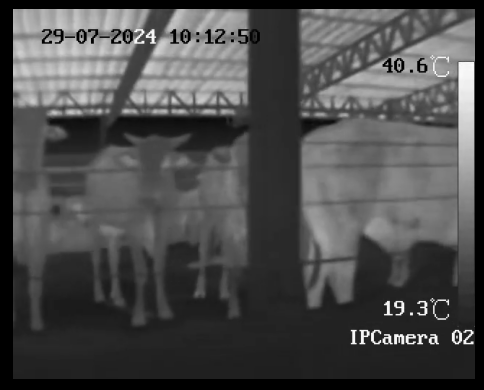

In [ ]:
img = imread('img.png')
plt.imshow(img)
plt.show()

In [ ]:
def type_convert(img, silent=False):
  """
  Parameters:
    img: np.array of image
  Raises:
    Exception: If image couldn't be converted to np.array
  Returns: Normalized image np.array
  """
  img = deepcopy(img)
  if not isinstance(img, np.ndarray):
    try: img = np.array(img)
    except Exception: raise Exception(f'Could not convert {type(np.array(None))} to np.array')
  if not silent: print("--- Warning: Image is now a normalized np.array ---")
  return img / 255.0 if type(img.flatten()[0]) not in (np.float16, np.float32, np.float64, np.float128) else img

def check_dims_number(img):
  """
  Parameters:
    img: np.array of image
  Raises:
    Exception: If image doesn't have 3 channels
  """
  if len(img.shape) != 3: raise Exception(f'Array must have three channels, got {img.shape}')

def get_digits(img, silent=False):
  """
  Parameters:
    img: np.array of image
    silent: If it should be verbose on image conversion
  Raises:
    Exception: If image doesn't have 3 channels
    Exception: If image couldn't be converted to np.array
  Returns: Tuple of cut digits from image (shape (2, 4, img_channels))
  """
  img = deepcopy(img)

  def preprocess(img):
    """
    Parameters:
      img: np.array of image
    Raises:
      Exception: If image doesn't have 3 channels
      Exception: If image couldn't be converted to np.array
    Returns: Preprocessed image for getting digits
    """
    img = type_convert(img, silent)
    check_dims_number(img)
    if img.shape[:2] != (512, 640): return cv.resize(img, (640, 512), interpolation=cv.INTER_LINEAR)
    return img

  img = preprocess(img)

  BOTTOM_DIGITS_LOCATION = [
    (403, 511, 425, 527),
    (403, 527, 425, 543),
    (403, 543, 425, 559),
    (403, 559, 425, 575)
  ]

  TOP_DIGITS_LOCATION = [
    (67, 511, 89, 527),
    (67, 527, 89, 543),
    (67, 543, 89, 559),
    (67, 559, 89, 575)
  ]


  return tuple([
    tuple(img[y1:y2, x1:x2] for (y1, x1, y2, x2) in BOTTOM_DIGITS_LOCATION),
    tuple(img[y1:y2, x1:x2] for (y1, x1, y2, x2) in TOP_DIGITS_LOCATION)
  ])

def get_bw_imgs(img, silent=False):
  """
  Parameters:
    img: Image to be optimized
  Raises:
    Exception: If image doesn't have 3 channels
    Exception: If image couldn't be converted to np.array
  Returns: String converted in black and white versions without background
  """
  img = deepcopy(img)

  img = type_convert(img, silent)
  check_dims_number(img)

  THRESHOLD = (15 / 255.0, 180 / 255.0)

  img_b = np.zeros(img.shape, np.float32)
  img_w = np.zeros(img.shape, np.float32)


  for y in range(img.shape[0]):
    for x in range(img.shape[1]):
      pix = img[y, x][0]
      if pix <= THRESHOLD[0]:  img_b[y, x] = [1., 1., 1.]
      if pix >= THRESHOLD[1]: img_w[y, x] = [1., 1., 1.]

  return tuple([img_b, img_w])

def to_str(img):
  """
  Parameters:
    img: Image to be converted to string (Optimized for numbers)
  Returns: String converted from image (No whitespaces)
  """
  preprocess = lambda img: cv.GaussianBlur(
    cv.erode((img * 255).astype(np.uint8), np.ones((2, 2), np.uint8), iterations=1),
    (3, 3),
    .2
  )

  return image_to_string(preprocess(img), config='--psm 6').replace(' ', '')

def get_temp_from_img_pixel(img, location, temp_tuple, silent=True):
  """
  Parameters:
    img: np.array of image
    location: (y, x) location tuple of pixel
    temp_tuple: (min, max) temperature tuple representing the temperature scale
    silent: If it should be verbose on image conversion
  Raises:
    Exception: Out of bounds location
    Exception: If image couldn't be converted to np.array
  Returns: °C tempertature from image in pixel
  """
  def get_temp_from_pixel(pixel, temp_tuple):
    """
    Parameters:
      pix: rgb color tuple representing image pixel
      temp_tuple: (min, max) temperature tuple representing the temperature scale
    Returns: °C tempertature from pixel
    """
    MIN_TEMP_PIXEL = 32 / 255.0
    MAX_TEMP_PIXEL = 159 / 255.0
    TEMP_PIXEL_RANGE = MAX_TEMP_PIXEL - MIN_TEMP_PIXEL

    pixel = pixel[0]
    if pixel < MIN_TEMP_PIXEL: pixel = MIN_TEMP_PIXEL
    if pixel > MAX_TEMP_PIXEL: pixel = MAX_TEMP_PIXEL

    min_temp = min(temp_tuple)
    max_temp = max(temp_tuple)
    temp_range = max_temp - min_temp

    temp = min_temp + ((pixel - MIN_TEMP_PIXEL) / TEMP_PIXEL_RANGE) * temp_range

    return temp

  img = type_convert(img, silent)
  check_dims_number(img)

  try: pixel = img[location]
  except Exception: raise Exception(f'Out of bounds for image shape {img.shape}, {location} is not acceptible')
  return get_temp_from_pixel(pixel, temp_tuple)

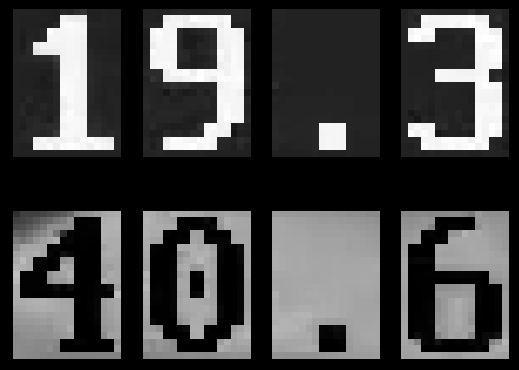

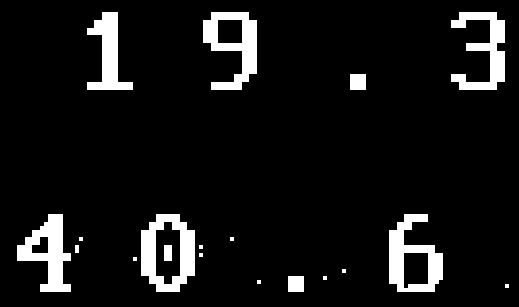

In [ ]:
_, axs = plt.subplots(ncols=4, nrows=2)
_, axs1 = plt.subplots(ncols=1, nrows=2)

digits = [i for i in get_digits(img, silent=True)]
for idx, tup in enumerate(digits):
  for jdx, im in enumerate(tup): axs[idx, jdx].imshow(im)

imgs = [None, None]
for idx, tup in enumerate(digits):
  for jdx, im in enumerate(tup):
    for i in get_bw_imgs(im, silent=True):
      if imgs[idx] is None: imgs[idx] = i
      else: imgs[idx] = np.hstack((imgs[idx], i))

[axs1[idx].imshow(i) for idx, i in enumerate(imgs)]

plt.show()

In [ ]:
_ = [print(to_str(i)) for i in imgs]

19.3

40.6

